In [1]:
from matplotlib import pyplot as plt
import numpy as np
from shapely.geometry import LineString
from pyemma import msm
import glob, re, os, tqdm
%ls COM_RL/RUN5/1000

ls: cannot access 'COM_RL/RUN5/1000': No such file or directory


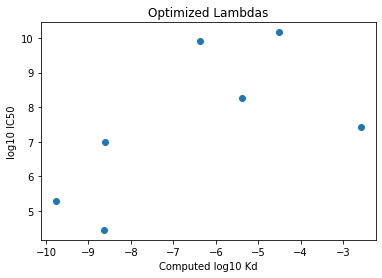

In [8]:
#opt = [-8.9,3.7,0.77,-8.31,-2.82,-9.95,4.56] # pre-CA restraints
opt = [2.36, 4130, 30200, 415, 0.175, 2.48, 2560000]
opt = [-8.63, -5.38, -4.52, -6.38, -9.76, -8.61, -2.59]
unopt = [-9.32,4.64,5.7,-7.67,1.02,-3.23,2.85]
exp = [86,3900,26000,20000,200,1100,1700]
plt.scatter(opt,[np.log(x) for x in exp])
plt.xlabel('Computed log10 Kd')
plt.ylabel('log10 IC50')
plt.title('Optimized Lambdas')
plt.show()

In [2]:
def P_accept_vs_delta_f_ij(delta_u_ij, delta_f_ij_range = (-100., 100., 0.5)):
    """Computes the average metropolis acceptance probability
    
        P_acc = min[ 1, exp(-(delta_u_ij + delta_f_ij))]
        
    for the specified range of delta_f_ij.
        
    INPUT
    delta_u_ij         - np.array() of sampled delta_u_ij values
    
    OPTIONS
    delta_f_ij_range   - tuple of min, max, and step in units kT
    
    RETURNS
    Pacc               - np.array() of acceptance probabilities 
    delta_f_ij_values  - np.array() of values where Pacc was evaluated
    """
    
    delta_f_ij_min  = delta_f_ij_range[0]
    delta_f_ij_max  = delta_f_ij_range[1] 
    delta_f_ij_step = delta_f_ij_range[2]
    
    delta_f_ij_values = np.arange(delta_f_ij_min, delta_f_ij_max, delta_f_ij_step)
    Pacc = np.zeros(delta_f_ij_values.shape)
    
    for i in range(delta_f_ij_values.shape[0]):
        delta_f_ij = delta_f_ij_values[i]
        Pacc[i] = np.mean( np.fmin(np.ones(delta_u_ij.shape), np.exp(-1.0*(delta_u_ij-delta_f_ij))) )
    
    return Pacc, delta_f_ij_values 

In [15]:
def analyze_ee(name, i_traj, dhdl_traj):
    
    if not os.path.exists(f'plots'):
        os.makedirs('plots')
        
    print(f'\n\nProcessing {name}...')
    # load samples lambdas, here we run the simulation for toy model in 10 lambda windows 

#    print ('# of steps=', len(i_traj), 'lambda indices=', np.unique(i_traj))

    # load delta_U(i-1, i)s, here I save them only in a numpy file
    try:
        dhdl_traj = np.load(dhdl_traj)       # or you can extract the dhdls from your xvg file
        i_traj = np.load(i_traj)
    except Exception as e:
        print(e)
        dhdl, i_traj = [],[]
        read_lines = False
        for line in open(dhdl_traj, 'r'):
            if '0.0000    0' in line:
                read_lines=True
            if not read_lines:
                continue
            dhdl.append(np.array([float(x) for x in line.split()[7:]]))
            i_traj.append(int(line.split()[1]))
        
        dhdl_traj = np.asarray(dhdl)
        i_traj = np.asarray(i_traj)
        
        
    #print ('dhdl: ', dhdl_traj.shape) #,  dhdl_traj[:2])

    n_ensembles = len(np.unique(i_traj))
    #print ('n_ensembles=', n_ensembles)
    
    plt.figure(figsize=(9,21))
    Ps=[]
    
    for j in range(n_ensembles-1):

        #######################
        # Forward transitions

        Ind_i = (i_traj == j)
        #print('i_traj.shape', np.shape(i_traj))
        Ind_i[(int(len(i_traj)/2)):] = False # take the last half of the trajectory
        #print('dhdl_shape',np.shape(dhdl_traj),type(dhdl_traj))
        #print('Ind_i_shape',np.shape(Ind_i),type(dhdl_traj))
        #print(Ind_i)
        delta_u_ij = dhdl_traj[Ind_i][j+1]  # [Ind_i, j+1] / delta_u = (u_{i+1} - u_i) values

        delta_u_bins = np.arange(-100., 100., 1.)
        counts, bin_edges = np.histogram(delta_u_ij, bins=delta_u_bins)
        bin_centers = (bin_edges[0:-1] + bin_edges[1:])/2.0

        plt.subplot(n_ensembles-1, 2, 2*j+1)
        plt.step(bin_centers, counts)
        # plt.step(bin_centers_biased, counts_biased, 'r-')
        #plt.xlabel('$\Delta u_{%d \\rightarrow %d}$'%(j,j+1), fontsize='large')
        #plt.ylabel('counts', fontsize='large')
        plt.tick_params(axis='both', labelsize='large')

        #######################
        # Back transitions

        Ind_j = (i_traj == j+1)
        Ind_j[(int(len(i_traj)/2)):] = False # take the last half of the trajectory
        delta_u_ji = dhdl_traj[Ind_j][j]  # [Ind_j, j] / delta_u = (u_{i+1} - u_i) values

        counts, bin_edges = np.histogram(delta_u_ji, bins=delta_u_bins)
        bin_centers = (bin_edges[0:-1] + bin_edges[1:])/2.0

        if (0):
            #plt.subplot(n_ensembles-1, 2, 2*j+1)
            plt.step(bin_centers, counts)
            # plt.step(bin_centers_biased, counts_biased, 'r-')
            plt.xlabel('$\Delta u_{%d \\rightarrow %d}$'%(j+1,j))


        ############################################
        # Forward and back acceptance probabilities

        ax = plt.subplot(n_ensembles-1, 2, 2*(j+1))
        #Pacc, delta_f_ij_values = P_accept_vs_delta_f_ij(delta_u_ij)
        #plt.plot(delta_f_ij_values, Pacc, 'b-', label='$p_{%d \\rightarrow %d}$'%(j,j+1))
        #Pacc, delta_f_ij_values = P_accept_vs_delta_f_ij(delta_u_ji)
        #plt.plot(-delta_f_ij_values, Pacc, 'r-', label='$p_{%d \\rightarrow %d}$'%(j+1,j))

        Pacc_ij, delta_f_ij_values = P_accept_vs_delta_f_ij(delta_u_ij)
        plt.plot(delta_f_ij_values, Pacc_ij, 'b-', label='$p_{%d \\rightarrow %d}$'%(j,j+1), zorder=1)
        Pacc_ji, delta_f_ji_values = P_accept_vs_delta_f_ij(delta_u_ji)
        plt.plot(-delta_f_ji_values, Pacc_ji, 'r-', label='$p_{%d \\rightarrow %d}$'%(j+1,j), zorder=2)

        #finding intersection
        first_line = LineString(np.column_stack((delta_f_ij_values, Pacc_ij)))
        second_line = LineString(np.column_stack((delta_f_ij_values, np.flip(Pacc_ji, axis=None))))
        intersection = first_line.intersection(second_line)
        #print('intersection',intersection)
        plt.scatter(intersection.xy[0], intersection.xy[1], marker='*', color='k', s=25, zorder=3)
        Ps.append(intersection.xy[1])    #appending all the intersections which are Pacc_(i,j)s

        plt.ylim(0,1)
        #plt.xlabel('$\\Delta \\tilde{f}_{ij}$ (kT)', fontsize='large')
        plt.tick_params(axis='both', labelsize='large')
        # Shrink current axis by 20%
        box = ax.get_position()
        ax.set_position([box.x0, box.y0, box.width * 0.8, box.height * 0.8])

        # Put a legend to the right of the current axis
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    plt.ylabel('Counts')
    plt.subplot(n_ensembles-1, 2, 2*j+1)
    plt.xlabel('$\Delta u_{i \\rightarrow j}$', fontsize='large')
    plt.subplot(n_ensembles-1, 2, 2*(j+1))
    plt.xlabel('$\\Delta \\tilde{f}_{ij}$ (kT)', fontsize='large')
    
    plt.tight_layout()
    plt.savefig(f'plots/Pijs_{name}.png', dpi=300)
    plt.close()
    
    #print (Ps)
    # plotting acceptance probabilities
    
    X=[]
    for i in range(n_ensembles-1):
        X.append('%d \u2192 %d'%(i,i+1))

    plt.figure(figsize=(6,3))
    plt.plot(np.arange(len(Ps)), Ps, '.-', label='pre-optimization')  # Ps are Pacc_(i,j)s
    plt.ylim(-0.01, 0.60)         
    plt.xticks(np.arange(len(X)), X, rotation=90)#, fontsize='large')
    plt.xlabel('thermodynamic index')
    plt.ylabel(r'$P_{accept}$')
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.savefig(f'plots/Pacc_{name}.png', dpi=300)
    plt.close()
    #plt.show()
    
    for i in tqdm.tqdm_notebook(range(1,101)):
        ndx = int(len(i_traj) * (i/100))
        try:
            M = msm.estimate_markov_model(i_traj[:ndx], 1)    # here, lagtime is 1 since the unit is step in our toy model
            forward = M.mfpt(0, n_ensembles-1)
            reverse = M.mfpt(n_ensembles-1, 0)
            #print ('tau_(1->N)=', forward)        # in unit of steps
            #print ('tau_(N->1)=', reverse)
            with open(f'plots/tau_{name}_{i}.txt','w') as f:
                f.write(f'tau_(1->N)=, {forward}\ntau_(N->1)=, {reverse}\n')
        except Exception as e:
            print(f'\nERROR',i, e)
            continue

In [18]:
%ls plots

Pacc_RL_post-opt-opt-opt_RUN1.png*  tau_RL_post-opt_RUN7_2.txt*
Pacc_RL_post-opt-opt-opt_RUN3.png*  tau_RL_post-opt_RUN7_30.txt*
Pacc_RL_post-opt-opt-opt_RUN4.png*  tau_RL_post-opt_RUN7_31.txt*
Pacc_RL_post-opt-opt-opt_RUN5.png*  tau_RL_post-opt_RUN7_32.txt*
Pacc_RL_post-opt-opt-opt_RUN6.png*  tau_RL_post-opt_RUN7_33.txt*
Pacc_RL_post-opt-opt-opt_RUN7.png*  tau_RL_post-opt_RUN7_34.txt*
Pacc_RL_post-opt-opt_RUN1.png*      tau_RL_post-opt_RUN7_35.txt*
Pacc_RL_post-opt-opt_RUN3.png*      tau_RL_post-opt_RUN7_36.txt*
Pacc_RL_post-opt-opt_RUN4.png*      tau_RL_post-opt_RUN7_37.txt*
Pacc_RL_post-opt-opt_RUN5.png*      tau_RL_post-opt_RUN7_38.txt*
Pacc_RL_post-opt-opt_RUN6.png*      tau_RL_post-opt_RUN7_39.txt*
Pacc_RL_post-opt-opt_RUN7.png*      tau_RL_post-opt_RUN7_3.txt*
Pacc_RL_post-opt_RUN1.png*          tau_RL_post-opt_RUN7_40.txt*
Pacc_RL_post-opt_RUN3.png*          tau_RL_post-opt_RUN7_41.txt*
Pacc_RL_post-opt_RUN4.png*          tau_RL_post-opt_RUN7_42.txt*
Pacc_RL_post-opt_RUN5.png* 


-------------------------------------



Processing RL_post-opt_RUN0...
RL/post-opt/RUN0 

-------------------------------------



Processing RL_post-opt_RUN1...


/tmp/ipykernel_25062/701361051.py:141: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm.tqdm_notebook(range(1,101)):


  0%|          | 0/100 [00:00<?, ?it/s]


-------------------------------------



Processing RL_post-opt_RUN3...


KeyboardInterrupt: 

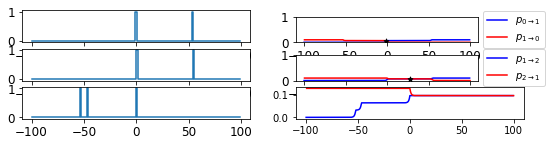

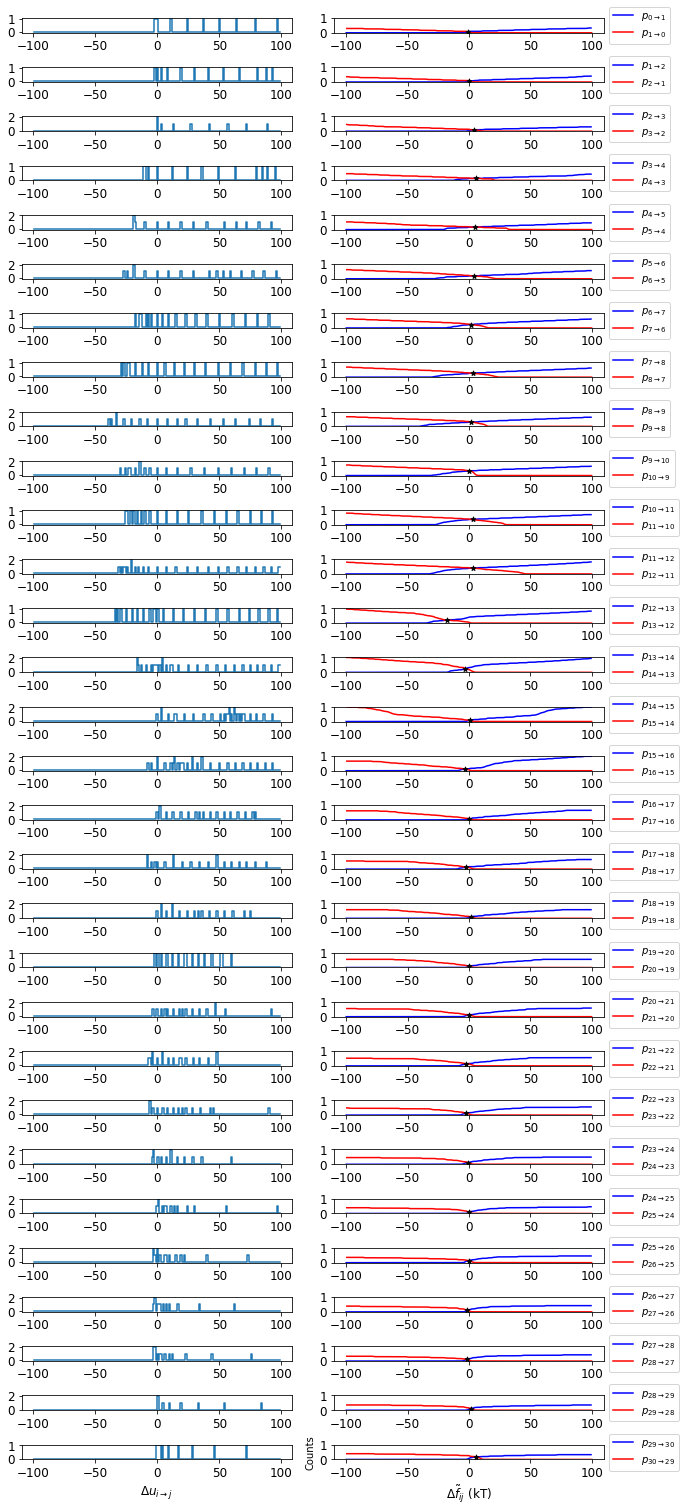

In [17]:

for i in glob.glob('RL/post-opt/RUN*'): # + glob.glob('L/RUN*') + glob.glob('L/RUN*/[0-9]*'):
    print('\n-------------------------------------\n')
    try:
        analyze_ee(re.sub('/','_',i), f'{i}/itraj.npy', f'{i}/dhdl.npy')
    except Exception as e:
        print(i,e)
        continue

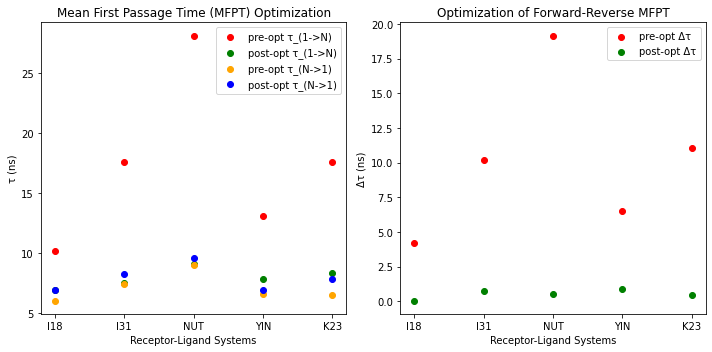

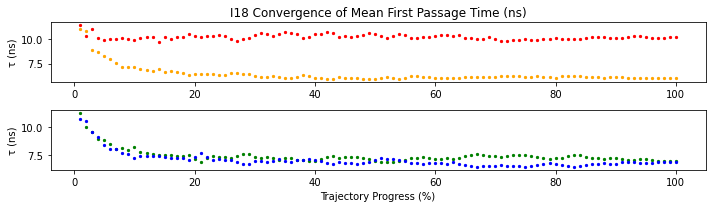

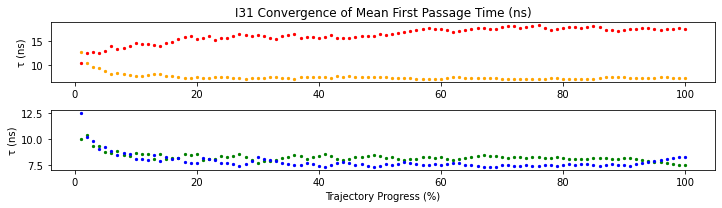

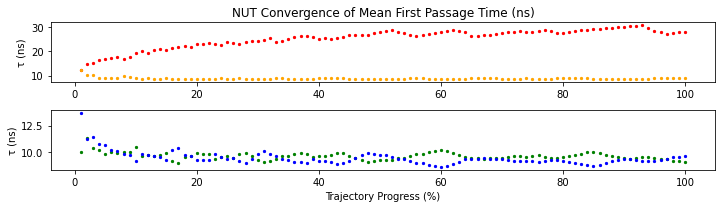

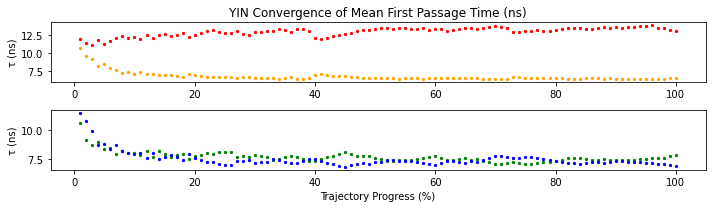

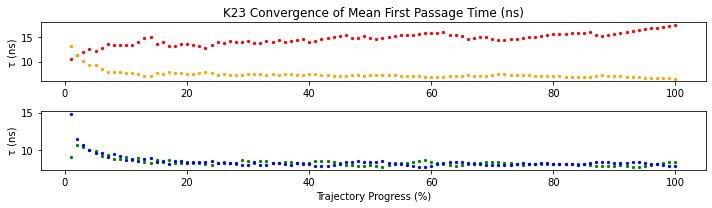

In [2]:
opt_tau, unopt_tau = [],[]
system_type = 'RL'
opt_level = 'post-opt'
for i in [3,4,5,6,7]:
    try:
      with open(f'plots/tau_{system_type}_{opt_level}_RUN{i}_100.txt') as f:
          lines = f.readlines()
          opt_tau.append([i] + [float(x.split()[1])/200 for x in lines])
      with open(f'plots/tau_{system_type}_pre-opt_RUN{i}_100.txt') as f:
          lines = f.readlines()
          unopt_tau.append([i] + [float(x.split()[1])/200 for x in lines])
    except Exception as e:
        continue
#print(opt_tau)
#print(unopt_tau)

fig = plt.figure(figsize=(10,5))
ax = plt.subplot(121)

ax.scatter([x[0] for x in unopt_tau],[x[1] for x in unopt_tau], c='r', label='pre-opt τ_(1->N)')
ax.scatter([x[0] for x in opt_tau],[x[1] for x in opt_tau], c='g', label='post-opt τ_(1->N)')
ax.scatter([x[0] for x in unopt_tau],[x[2] for x in unopt_tau], c='orange', label='pre-opt τ_(N->1)')
ax.scatter([x[0] for x in opt_tau],[x[2] for x in opt_tau], c='b', label='post-opt τ_(N->1)')

plt.xticks([3,4,5,6,7],['I18','I31','NUT','YIN','K23'])
plt.xlabel('Receptor-Ligand Systems')
plt.ylabel('τ (ns)')
# Shrink current axis by 20%
#box = ax.get_position()
#ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
plt.title('Mean First Passage Time (MFPT) Optimization')
# Put a legend to the right of the current axis
#ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.legend(loc='upper right')
ax2 = plt.subplot(122)

ax2.scatter([x[0] for x in opt_tau], [abs(unopt_tau[x][1]-unopt_tau[x][2])
     for x in range(len(opt_tau))], c='r', label='pre-opt Δτ')
ax2.scatter([x[0] for x in opt_tau], [abs(opt_tau[x][1]-opt_tau[x][2])
     for x in range(len(opt_tau))], c='g', label='post-opt Δτ')
ax2.legend(loc='best')

plt.xticks([3,4,5,6,7],['I18','I31','NUT','YIN','K23'])
plt.title('Optimization of Forward-Reverse MFPT')
plt.xlabel('Receptor-Ligand Systems')
plt.ylabel('Δτ (ns)')

plt.tight_layout()
plt.show()
#plt.savefig(f'plots/MFPT.png')
plt.close()

ligands = ['I18','I31','NUT','YIN','K23']
for i in [3,4,5,6,7]:

    if os.path.exists(f'plots/tau_{system_type}_pre-opt_RUN{i}_100.txt') and os.path.exists(
        f'plots/tau_{system_type}_{opt_level}_RUN{i}_100.txt'):
        taus = [] # pre-opt
        plt.figure(figsize=(10,3))
        plt.ylabel('MFPT (ns)')
        for j in range(1,101):
            if os.path.exists(f'plots/tau_{system_type}_pre-opt_RUN{i}_{j}.txt'):
                with open(f'plots/tau_{system_type}_pre-opt_RUN{i}_{j}.txt') as f:
                    lines = f.readlines()
                taus.append([j] + [float(x.split()[1])/200 for x in lines])
        taus = np.asarray(taus)        
        plt.subplot(2,1,1)
        plt.scatter(taus[:,0],taus[:,1], color='r', s=5)
        plt.scatter(taus[:,0],taus[:,2], color='orange', s=5)
        plt.title(f'{ligands[i-3]} Convergence of Mean First Passage Time (ns)')
        plt.ylabel('τ (ns)')
        
        taus = [] # post-opt
        for j in range(1,101):
            if os.path.exists(f'plots/tau_{system_type}_{opt_level}_RUN{i}_{j}.txt'):
                with open(f'plots/tau_{system_type}_{opt_level}_RUN{i}_{j}.txt') as f:
                    lines = f.readlines()
                taus.append([j] + [float(x.split()[1])/200 for x in lines])
        taus = np.asarray(taus)        
        plt.subplot(2,1,2)
        plt.scatter(taus[:,0],taus[:,1], color='g', s=5)
        plt.scatter(taus[:,0],taus[:,2], color='b', s=5)
#        for j in range(len(taus)):
#            plt.scatter(taus[j][0],taus[j][1], color='green')
#            plt.scatter(taus[j][0],taus[j][2], color='blue')
        plt.xlabel('Trajectory Progress (%)')
        plt.ylabel('τ (ns)')
        plt.tight_layout()
        plt.show()
        #plt.savefig(f'plots/MFPT_convergence_RUN{i}.png')
        plt.close()

In [6]:
# 1st way

# in this toy model, end states are 0 and 9!!
i = 0
source, sink = 0,9    
switch_i = []
target = source # start at 0
while i < i_traj.shape[0]:
    
            if i_traj[i] == target:
                # mark this value of i
                switch_i.append(i)
                #print (i, x_positions[i])
                # change the target we're looking for
                if target == source:
                    target = sink
                else:
                    target = source
            i += 1
        
        #print('switch_i', switch_i)
switch_i = np.array(switch_i)

times_source2sink = (switch_i[1::2] - switch_i[0:-1:2])
print ('# of transitions from lambda_1 to lambda_N:', len(times_source2sink))
times_sink2source = switch_i[2::2] - switch_i[1:-1:2]
print ('# of transitions from lambda_N to lambda_1:', len(times_sink2source))
        
print ('tau_(1->N)=', np.mean(times_source2sink))    # in unit of steps
print ('tau_(N->1)=', np.mean(times_sink2source))

NameError: name 'i_traj' is not defined

In [8]:
# 2nd way to compute the mean round-trip time between end states, 0 and 9

# computing round-trip time using the MFPT function in pyemma
from pyemma import msm
M = msm.estimate_markov_model(i_traj, 1)    # here, lagtime is 1 since the unit is step in our toy model

#mfpts = np.zeros([n_ensembles, n_ensembles])
#print (mfpts.shape)

#for i in range(n_ensembles):
#    for j in range(n_ensembles):
#        mfpts[i,j] = M.mfpt(i, j)
#        print (i, 'to', j , mfpts[i,j])

print ('tau_(1->N)=', M.mfpt(0, 9))        # in unit of steps
print ('tau_(N->1)=', M.mfpt(9, 0))

/Users/sizhang/anaconda3/envs/py36/lib/python3.6/site-packages/pyemma/util/log.py:65: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  D = yaml.load(f2)
/Users/sizhang/anaconda3/envs/py36/lib/python3.6/site-packages/pyemma/__init__.py:130: UserWarning: You are not using the latest release of PyEMMA. Latest is 2.5.7, you have 2.5.4.
  .format(latest=latest, current=current), category=UserWarning)


tau_(1->N)= 13163.702577991766
tau_(N->1)= 13626.172265652474
